In [1]:
# Setup:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from unityagents import UnityEnvironment
from tqdm.auto import tqdm
from IPython.display import clear_output

# Get rid of ugly tensorflow future warnings:
clear_output()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.logging.set_verbosity(tf.logging.ERROR)

## Create a ReplayBuffer

To break correlation between observations and stabilize training, we are going to use Experience Replay.
For this, we are going to need a simple Replay Buffer to store experienced tuples of shape (observation, action, reward, next_observation).

In [2]:
## Create a ReplayBuffer:
class ReplayBuffer:
    def __init__(self, observation_dim, action_dim, max_size):
        self.observations = np.zeros([observation_dim, max_size], dtype=np.float32)
        self.next_observations = np.zeros([observation_dim, max_size], dtype=np.float32)
        self.actions = np.zeros(max_size, dtype=np.int32)
        self.rewards = np.zeros(max_size, dtype=np.float32)
        self.dones = np.zeros(max_size, dtype=np.float32)
        self.pointer, self.size, self.max_size = 0, 0, max_size
        
    def store(self, observation, action, reward, next_observation, done):
        self.observations[:, self.pointer] = observation
        self.next_observations[:, self.pointer] = next_observation
        self.actions[self.pointer] = action
        self.rewards[self.pointer] = reward
        self.dones[self.pointer] = done
        self.pointer = (self.pointer + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        return {'observations': self.observations[:, idxs].T,
                'actions': self.actions[idxs],
                'rewards': self.rewards[idxs],
                'next_observations': self.next_observations[:, idxs].T,
                'dones': self.dones[idxs]}

## Creating a Estimator Class

To further increase stability, we will use two Neural Networks during training: A target network for estimating the Q-Values of the following observations and a main network which is used to choose actions during training and consistently updated with regard to the target values derived from the imidiate reward and the values from the target network. The target network will be periodically replaced by the main network.

We will wrap the needed functionality inside a class called DQN.

In [3]:
class DQN():
    def __init__(self, input_dimension, output_dimension, hidden_layer_sizes, learning_rate, epsilon, scope):
        
        # Save attributes:
        self.output_dimension = output_dimension
        # We need to define a scope to be able retrieve the tensors of an individual model later on
        self.scope = scope
        self.learning_rate = learning_rate
        self.optimizer = tf.train.AdamOptimizer(learning_rate)
        
        with tf.variable_scope(self.scope):
            # Define the model graph, starting with the input placeholders
            self.observations = tf.placeholder(shape=(None, input_dimension), dtype=tf.float32, name='observations')
            self.targets = tf.placeholder(shape=(None, ), dtype=tf.float32, name='targets')
            self.actions = tf.placeholder(shape=(None, ), dtype=tf.int32, name='actions')
            
            # Getting ready:
            Z = self.observations

            # Define the Neural Network:
            for layer_size in hidden_layer_sizes:
                Z = tf.layers.Dense(units=layer_size, activation='relu')(Z)

            # Define the final layer:
            self.predict_operation = tf.layers.Dense(units=self.output_dimension)(Z)

            # Compute values of the selected actions:
            selected_action_values = tf.reduce_sum(self.predict_operation * tf.one_hot(self.actions, 
                                                                self.output_dimension), reduction_indices=[1])

            # Compute and optimize cost
            self.cost = tf.reduce_mean(tf.losses.huber_loss(self.targets, selected_action_values))
            self.train_operation = self.optimizer.minimize(self.cost)
    
    # A function to copy the variables of another DQN to this one:
    def copy_from(self, other):
        mine = [t for t in tf.trainable_variables() if t.name.startswith(self.scope)]
        mine = sorted(mine, key = lambda x: x.name)
        other = [t for t in tf.trainable_variables() if t.name.startswith(other.scope)]
        other = sorted(other, key = lambda x: x.name)
        
        operations = []
        for p, q in zip(mine, other):
            operations.append(p.assign(q))
        self.session.run(operations)
        
    # A function to save the params of the DQN:
    def save(self, path):
        params = [t for t in tf.trainable_variables() if t.name.startswith(self.scope)]
        params = self.session.run(params)
        np.savez(path, *params)
        
    # A function to load params to the DQN:
    def load(self, path):
        params = [t for t in tf.trainable_variables() if t.name.startswith(self.scope)]
        npz = np.load(path)
        operations = []
        for p, f in zip(params, npz.files):
            operations.append(p.assign(npz[f]))
        self.session.run(operations)
        
    def set_session(self, session):
        self.session = session
        
    def predict(self, observations):
        return self.session.run(self.predict_operation, feed_dict={self.observations: observations})
        
    def update(self, observations, actions, targets):
        c, _ = self.session.run([self.cost, self.train_operation],
                                feed_dict={self.observations: observations, self.actions: actions, 
                                           self.targets: targets})
        return c

## Wrapping it into our Agent

We will now wrap the networks and the buffer inside a class called Agent and equip this class with the necessary functionality to interact with the environment and learn.

In [4]:
class Agent():
    def __init__(self, agent_config):
        
        # Save generell attributes
        self.action_space = [i for i in range(agent_config.get('number_of_actions'))]
        self.observation_dim = agent_config.get('observation_dim')
        # Save attributes for the replay memory:
        self.memory_size = agent_config.get('memory_size')
        self.batch_size = agent_config.get('batch_size')
        # Save attributes for the Neural Networks
        self.hidden_layer_sizes = agent_config.get('hidden_layer_sizes')
        self.learning_rate = agent_config.get('learning_rate')
        # Save attributes for the agent itself concerning exploration, network updating and discouting
        self.epsilon = agent_config.get('epsilon')
        self.min_epsilon = agent_config.get('min_epsilon')
        self.epsilon_decay_rate = agent_config.get('epsilon_decay_rate')
        self.gamma = agent_config.get('gamma')
        self.update_period = agent_config.get('update_period')
        self.num_updates = 0
        
        # Initialize the parts:
        self.memory = ReplayBuffer(observation_dim=self.observation_dim,
                                   action_dim=len(self.action_space),
                                   max_size=self.memory_size)
        self.target_network = DQN(input_dimension=self.observation_dim,
                                 output_dimension=len(self.action_space),
                                 hidden_layer_sizes=self.hidden_layer_sizes,
                                 learning_rate=self.learning_rate,
                                 epsilon=self.epsilon,
                                 scope='target_network')
        self.main_network = DQN(input_dimension=self.observation_dim,
                                 output_dimension=len(self.action_space),
                                 hidden_layer_sizes=self.hidden_layer_sizes,
                                 learning_rate=self.learning_rate,
                                 epsilon=self.epsilon,
                                 scope='main_network')
        
        # Initalize a shared session:
        self.session = tf.InteractiveSession()
        # Initialize variables:
        init = tf.global_variables_initializer()
        self.session.run(init)
        # Set sessiions for the networks:
        self.target_network.set_session(self.session)
        self.main_network.set_session(self.session)
        # Copy the weights from the main to the target network:
        self.target_network.copy_from(self.main_network)
        
    def choose_action(self, observation):
        observation = observation.reshape(1, self.observation_dim)
        # Decrease the learning rate:
        self.epsilon = max(self.min_epsilon, self.epsilon - self.epsilon_decay_rate)
        # Are we going to explore?
        if np.random.rand() < self.epsilon:
            return np.random.choice(len(self.action_space))
        # Seems like we are about te exploit.
        action_values = self.main_network.predict(observation)[0]
        # Casting is necessary for the environment
        return np.argmax(action_values).astype(np.int32)
        
    def add_memory(self, observation, action, reward, next_observation, done):
        self.memory.store(observation, action, reward, next_observation, done)
        
    def update_main(self):
        # Sample experience:
        experience = self.memory.sample_batch(self.batch_size)
        observations = experience['observations']
        actions = experience['actions']
        rewards = experience['rewards']
        next_observations = experience['next_observations']
        # We are going to use the dones to adjust target values once a terminal observation is reached.
        dones = experience['dones']
        
        # Calculate update targets:
        next_Qs = self.target_network.predict(next_observations)
        targets = rewards + dones * self.gamma * next_Qs
        
        # Update
        self.main_network.update(observations, actions, targets)
        self.num_updates += 1
        
        # Replace the target_network with the main_network after each update_period:
        if self.num_updates % self.update_period == 0:
            self.target_network.copy_from(self.main_network)
        
        return cost

## Define an episode

In [5]:
# A function used to play one episode with a given agent
def play_one(agent, env, brain_name, train_mode=True):
    
    # Initialize the return
    episode_return = 0
    
    # Start episode
    env_info = env.reset(train_mode=train_mode)[brain_name]
    observation = env_info.vector_observations[0]
    done = False
    
    # Play
    while not done:
        # Interact with environment
        action = agent.choose_action(observation)
        env_info = env.step(action)[brain_name]
        next_observation = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        episode_return += reward     

        # Add memory
        agent.add_memory(observation, action, reward, next_observation, done)
        # Train from memory
        cost = agent.learn()
        
        # Perform transition
        observation = next_observation
    
    return episode_return

## Training Day

We are now going to train our agent by plaing many episodes defined above.

In [6]:
# A helper for evaluation and smooth plotting:
def smooth(x):
    n = len(x)
    y = np.zeros(n)
    for i in range(n):
        start = max(0, i-99)
        y[i] = float(x[start:(i+1)].sum()) / (i - start + 1)
    return y

In [7]:
# Define parameters for our agent:
observation_dim = 37
hidden_layer_sizes = [256, 256]
gamma = 0.99 # Discount factor for future rewards
number_of_actions = 4 # Number of possible actions
target_update_period = 10000 # The number of timesteps after which the target update is periodically replaced
max_experiences = 500000 # Maximum size of the ReplayBuffer
min_experiences = 50000 # Minimum amount of experience required before starting training
batch_size = 32 # Number of (observation, action, reward, next_observation) tuples that will be sampled from experience
learning_rate = 10e-5
epsilon = 1 # We start by acting completely random and decrease the exploration in a linear manner after that.
min_epsilon = 0.1 # The minimum amount of exploration we will perform

agent_config = {
    'observation_dim': observation_dim,
    'number_of_actions': number_of_actions,
    'memory_size': max_experiences,
    'batch_size': batch_size,
    'hidden_layer_sizes': hidden_layer_sizes,
    'learning_rate': learning_rate,
    'epsilon': epsilon,
    'min_epsilon': min_epsilon,
    'epsilon_decay_rate': (epsilon - min_epsilon) / 50000,
    'gamma': gamma,
    'update_period': target_update_period
}

agent = Agent(agent_config)
env = UnityEnvironment(file_name="Banana_Windows/Banana.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


___

**In the next cell, actual training happens.
You can skip this an simply load the pretrained weights further down the road.
To do so, just skip ahead to chapter "Agent Evaluation"**
___

Average Return over the last 100 episodes: 0.78
Average Return over the last 100 episodes: 5.37
Average Return over the last 100 episodes: 7.27
Average Return over the last 100 episodes: 7.85
Average Return over the last 100 episodes: 10.05
Average Return over the last 100 episodes: 11.14
Average Return over the last 100 episodes: 10.97
Average Return over the last 100 episodes: 12.09
Average Return over the last 100 episodes: 11.16
Average Return over the last 100 episodes: 11.68
Average Return over the last 100 episodes: 13.18
Average Return over the last 100 episodes: 13.11
Average Return over the last 100 episodes: 12.33
Average Return over the last 100 episodes: 10.15
Average Return over the last 100 episodes: 12.3
Average Return over the last 100 episodes: 13.11
Average Return over the last 100 episodes: 13.53
Average Return over the last 100 episodes: 13.81
Average Return over the last 100 episodes: 13.55
Average Return over the last 100 episodes: 12.28
Average Return over the l

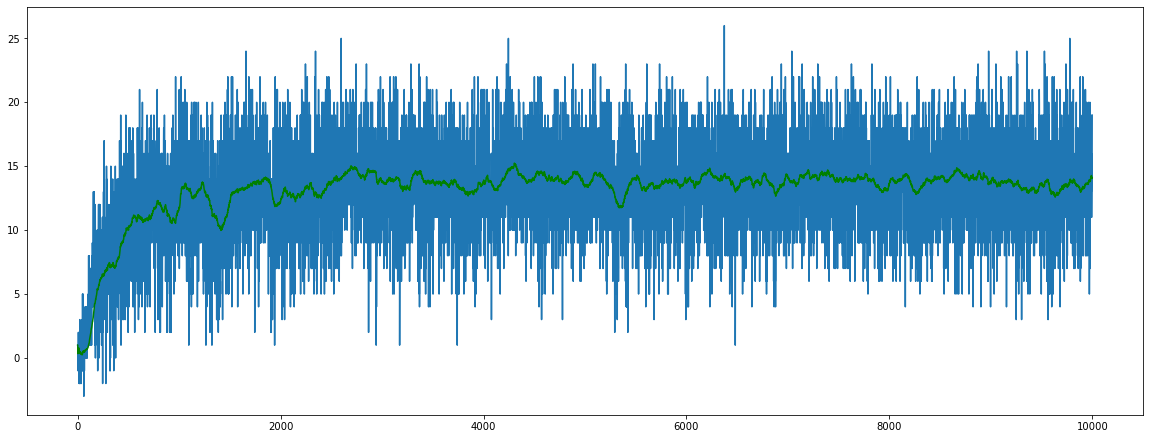

In [8]:
# Populating replay buffer:
env_info = env.reset(train_mode=True)[brain_name]
observation = env_info.vector_observations[0]
done = False

experience_counter = 0
print('Filling Replay Buffer...')
for True:
    action = np.random.choice(4)
    env_info = env.step(action)[brain_name]
    reward = env_info.rewards[0]
    next_observation = env_info.vector_observations[0]
    done = env_info.local_done[0]

    # Add memory
    agent.add_memory(observation, action, reward, next_observation, done)
    
    if done:
        env_info = env.reset(train_mode=True)[brain_name]
        observation = env_info.vector_observations[0]
        
    experience_counter += 1
    if experience_counter >= min_experiences:
        break
        
# Now we are finally able to train our agent
num_episodes = 5000
episode_returns = np.zeros(num_episodes)

print('Starting Training...')
for i in tqdm(range(num_episodes)):
    episode_returns[i] = play_one(agent, env, brain_name)
    if i % 100 == 0 and i > 0:
        print(f'Average Return over the last 100 episodes: {smooth(episode_returns[:i+1])[-1]}')
        
# Plot the results:
plt.figure(figsize=(20,7.5))
plt.plot(episode_returns)
plt.plot(smooth(episode_returns), color='green')

# Print the return over the last 100 episodes:
print(f'Over the last 100 episodes, the agent received an average return of {smooth(episode_returns)[-1]}')

# Save weights
agent.main_network.save('weights/network_weights.npz')

## Agent Evaluation

In [9]:
# Load the pre-trained weights:
agent.main_network.load('weights/network_weights.npz')
agent.target_network.load('weights/network_weights.npz')

# Set exploration to zero:
agent.epsilon = 0

In [10]:
# Play 100 episodes and print the average reward (repeated for 10 runs):
for i in tqdm(range(10)):
    cache = np.zeros(100)
    for j in range(100):
        cache[j] = play_one(agent, env, brain_name)
    print(f'In run {i+1} the Agent received an average return of {np.mean(cache)} over 100 episodes.')

In run 1 the Agent received an average return of 14.14 over 100 episodes.
In run 2 the Agent received an average return of 14.45 over 100 episodes.
In run 3 the Agent received an average return of 13.8 over 100 episodes.
In run 4 the Agent received an average return of 13.35 over 100 episodes.
In run 5 the Agent received an average return of 13.46 over 100 episodes.
In run 6 the Agent received an average return of 14.47 over 100 episodes.
In run 7 the Agent received an average return of 14.44 over 100 episodes.
In run 8 the Agent received an average return of 14.38 over 100 episodes.
In run 9 the Agent received an average return of 14.49 over 100 episodes.
In run 10 the Agent received an average return of 14.01 over 100 episodes.



In [12]:
# Watch Time
play_one(agent, env, brain_name, train_mode=False)

8.0

In [ ]:
# Shutdown
env.close()